### 0. Task
- 데이터 : 시작가, 최고가, 최저가, 종가, 거래량
- task : 5개의 피쳐 & 시계열(7일치) => 8일차 종가 예측

### 1. 데이터 로드

In [262]:
import pandas as pd

path = r'C:\Users\SeoJeongBin\Desktop\Code\Pytorch\Pytorch_exercise\data\stock.csv'
df = pd.read_csv(path)
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,53.304001,53.924500,53.099998,53.856998,53.856998,31092000
1,2017-12-19,53.759998,53.841999,53.177502,53.534000,53.534000,26774000
2,2017-12-20,53.589001,53.668999,53.076000,53.247501,53.247501,25372000
3,2017-12-21,53.247501,53.466499,53.089699,53.181499,53.181499,19914000
4,2017-12-22,53.055500,53.209999,52.972000,53.006001,53.006001,15102000
...,...,...,...,...,...,...,...
1254,2022-12-12,93.089996,93.875000,91.900002,93.559998,93.559998,27380900
1255,2022-12-13,98.070000,99.800003,95.379997,95.849998,95.849998,34788500
1256,2022-12-14,95.540001,97.220001,93.940002,95.309998,95.309998,26452900
1257,2022-12-15,93.540001,94.029999,90.430000,91.199997,91.199997,28298800


In [263]:
df = df.drop(columns = ['Date','Adj Close'])
df

,Open,High,Low,Close,Volume
0,53.304001,53.924500,53.099998,53.856998,31092000
1,53.759998,53.841999,53.177502,53.534000,26774000
2,53.589001,53.668999,53.076000,53.247501,25372000
3,53.247501,53.466499,53.089699,53.181499,19914000
4,53.055500,53.209999,52.972000,53.006001,15102000
...,...,...,...,...,...
1254,93.089996,93.875000,91.900002,93.559998,27380900
1255,98.070000,99.800003,95.379997,95.849998,34788500
1256,95.540001,97.220001,93.940002,95.309998,26452900
1257,93.540001,94.029999,90.430000,91.199997,28298800


In [264]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### 2. 학습 데이터 분할
- 시계열은 random split 하면안됨!

In [265]:
train_size = int(len(df)*0.7)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]

In [266]:
train

,Open,High,Low,Close,Volume
0,53.304001,53.924500,53.099998,53.856998,31092000
1,53.759998,53.841999,53.177502,53.534000,26774000
2,53.589001,53.668999,53.076000,53.247501,25372000
3,53.247501,53.466499,53.089699,53.181499,19914000
4,53.055500,53.209999,52.972000,53.006001,15102000
...,...,...,...,...,...
876,125.669502,126.411499,125.046997,126.351997,22550000
877,126.522003,126.862000,125.648499,126.032997,22182000
878,126.247498,126.523499,124.149948,125.696503,26316000
879,125.523003,127.196503,125.514999,126.371002,25756000


In [267]:
test

,Open,High,Low,Close,Volume
881,125.739998,127.036751,125.134247,126.455002,26256000
882,126.449997,127.269997,126.026497,126.999496,20984000
883,126.550003,127.795998,126.251999,126.461502,19694000
884,127.053497,127.535500,126.959999,127.281998,18934000
885,126.957001,127.504997,126.444000,126.995003,33484000
...,...,...,...,...,...
1254,93.089996,93.875000,91.900002,93.559998,27380900
1255,98.070000,99.800003,95.379997,95.849998,34788500
1256,95.540001,97.220001,93.940002,95.309998,26452900
1257,93.540001,94.029999,90.430000,91.199997,28298800


In [268]:
# 정규화

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

print(train.shape)
train

(881, 5)


array([[0.0592211 , 0.04865653, 0.05955819, 0.06505927, 0.20610218],
       [0.06508021, 0.04758536, 0.06056287, 0.06089478, 0.16926043],
       [0.06288307, 0.04533918, 0.0592471 , 0.05720088, 0.15729839],
       ...,
       [0.99647288, 0.9912619 , 0.98057437, 0.99130352, 0.16535272],
       [0.98716384, 1.        , 0.99826945, 1.        , 0.16057472],
       [0.98950872, 0.9895156 , 0.98644722, 0.98964021, 0.39563496]])

### 3. Buid Dataset

In [269]:
import numpy as np

def create_window(data, sequence_length):
    x_data = []
    y_data = []
    for i in range(0, len(data)-sequence_length):
        x = data[i:i+sequence_length] # 7일치 전체 데이터
        y = [data[i+sequence_length, -2]] #8일차의 target value 1개 (종가가 끝에서 두번째라 -2)
        x_data.append(x)
        y_data.append(y)
    x_data = np.array(x_data)
    y_data = np.array(y_data) # ndarray 변경
    return x_data, y_data

In [270]:
seq_length = 7

x_train, y_train = create_window(train, seq_length)
x_test, y_test = create_window(test, seq_length)

print(x_train.shape)
print(y_train.shape)

(874, 7, 5)
(874, 1)


In [271]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y) :
        super().__init__()
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index) :
        return self.x[index], self.y[index]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [272]:
print(f'train_dataset 개수 : {len(train_dataset)}개')

train_dataset[0] # (0번째 x train의 torch, 0번째 y train의 torch)

train_dataset 개수 : 874개


(tensor([[0.0592, 0.0487, 0.0596, 0.0651, 0.2061],
         [0.0651, 0.0476, 0.0606, 0.0609, 0.1693],
         [0.0629, 0.0453, 0.0592, 0.0572, 0.1573],
         [0.0585, 0.0427, 0.0594, 0.0563, 0.1107],
         [0.0560, 0.0394, 0.0579, 0.0541, 0.0697],
         [0.0541, 0.0367, 0.0519, 0.0519, 0.0706],
         [0.0536, 0.0356, 0.0505, 0.0472, 0.1579]]),
 tensor([0.0464]))

### 4. Model
- task : 7일(seq_length) 만큼의 데이터를 입력받아서, 8일차의 종가 예측
- regression이기 때문에 output dimension은 1임
    - 하지만 이렇게하면 state vector size도 1인데, 이거는 모델 입장에서 굉장히 부담스럽다. hidden layer state 정보를 고작 압축해서 size 1로 주는거니까
- 그래서 보통 hidden size를 정하고, (예를들어 여기서는 10) 마지막에 output에서 FC로 예측하는 방식

In [273]:
# hyper parameters
seq_length = 7
data_dim = 5 # 입력 데이터 차원 개수 (칼럼 수)
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
# layers <- rnn 셀을 몇개를 줄 것인가

![rnn.png](rnn.png)

In [274]:
import torch.nn as nn

class myModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(myModel, self).__init__()
        self.layer_rnn = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.layer_fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        output, _status = self.layer_rnn(x)
        output = output[:,-1] # 직전 state정보만을 취급하지!! 7개중에서 (위의 그림 참고)
        output = self.layer_fc(output)
        return output

### batchsize

In [275]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=True) # test는 shuffle False인듯도?

loader = iter(train_dataloader)
x, y = next(loader) # 첫번째 batch가 나오는거임 이렇게하면
print(x.shape)
print(y.shape)

torch.Size([30, 7, 5])
torch.Size([30, 1])


#### optimizer

In [276]:
model = myModel(data_dim, hidden_dim, output_dim, layers=3)

import torch.optim as optim 

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss() # 회귀니까


### 5. 학습

In [277]:
loss_graph = [] # 그래프 그릴 목적인 loss.
epochs = 1000
from tqdm import tqdm


for epoch in tqdm(range(epochs)):
    # train mode
    model.train()
    train_loss = 0
    
    for x, y in train_dataloader :
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        train_loss += loss.item() 
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0 : 
        # eval mode
        model.eval()
        val_loss = 0
        with torch.no_grad() : 
            for x,y in test_dataloader:
                pred = model(x)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
                
        print(f'[Epoch : {epoch+1}/{epochs}] [train_loss : {train_loss/len(train_dataloader)}] [val_loss : {val_loss/len(test_dataloader)}]')
        loss_graph.append(train_loss/len(train_dataloader))
        # loss 길이로 꼭 나눠서 평균으로 봐야함!

  0%|          | 1/1000 [00:00<08:51,  1.88it/s]

[Epoch : 1/1000] [train_loss : 0.06546063510080179] [val_loss : 0.11169520364357875]


 10%|█         | 101/1000 [00:40<05:55,  2.53it/s]

[Epoch : 101/1000] [train_loss : 0.0007189265777318118] [val_loss : 0.00881864889883078]


 20%|██        | 201/1000 [01:19<05:19,  2.50it/s]

[Epoch : 201/1000] [train_loss : 0.0007010965239411841] [val_loss : 0.009849069604220299]


 30%|███       | 301/1000 [02:01<04:34,  2.55it/s]

[Epoch : 301/1000] [train_loss : 0.00027329431468388067] [val_loss : 0.011147572050014367]


 40%|████      | 401/1000 [02:39<04:08,  2.41it/s]

[Epoch : 401/1000] [train_loss : 0.0002825177264943098] [val_loss : 0.010160341321562346]


 50%|█████     | 501/1000 [03:20<04:04,  2.04it/s]

[Epoch : 501/1000] [train_loss : 0.00021653834580016943] [val_loss : 0.012958433479070663]


 60%|██████    | 601/1000 [04:14<04:54,  1.35it/s]

[Epoch : 601/1000] [train_loss : 0.00019706589252261136] [val_loss : 0.013262368201349791]


 70%|███████   | 701/1000 [05:13<02:11,  2.27it/s]

[Epoch : 701/1000] [train_loss : 0.00024034621771230983] [val_loss : 0.01976976214120021]


 80%|████████  | 801/1000 [06:06<01:27,  2.26it/s]

[Epoch : 801/1000] [train_loss : 0.00012657573630955692] [val_loss : 0.015074640333365936]


 90%|█████████ | 901/1000 [06:56<02:45,  1.67s/it]

[Epoch : 901/1000] [train_loss : 0.00018279926710723277] [val_loss : 0.01614340774428386]


100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


### 6. 결과 시각화

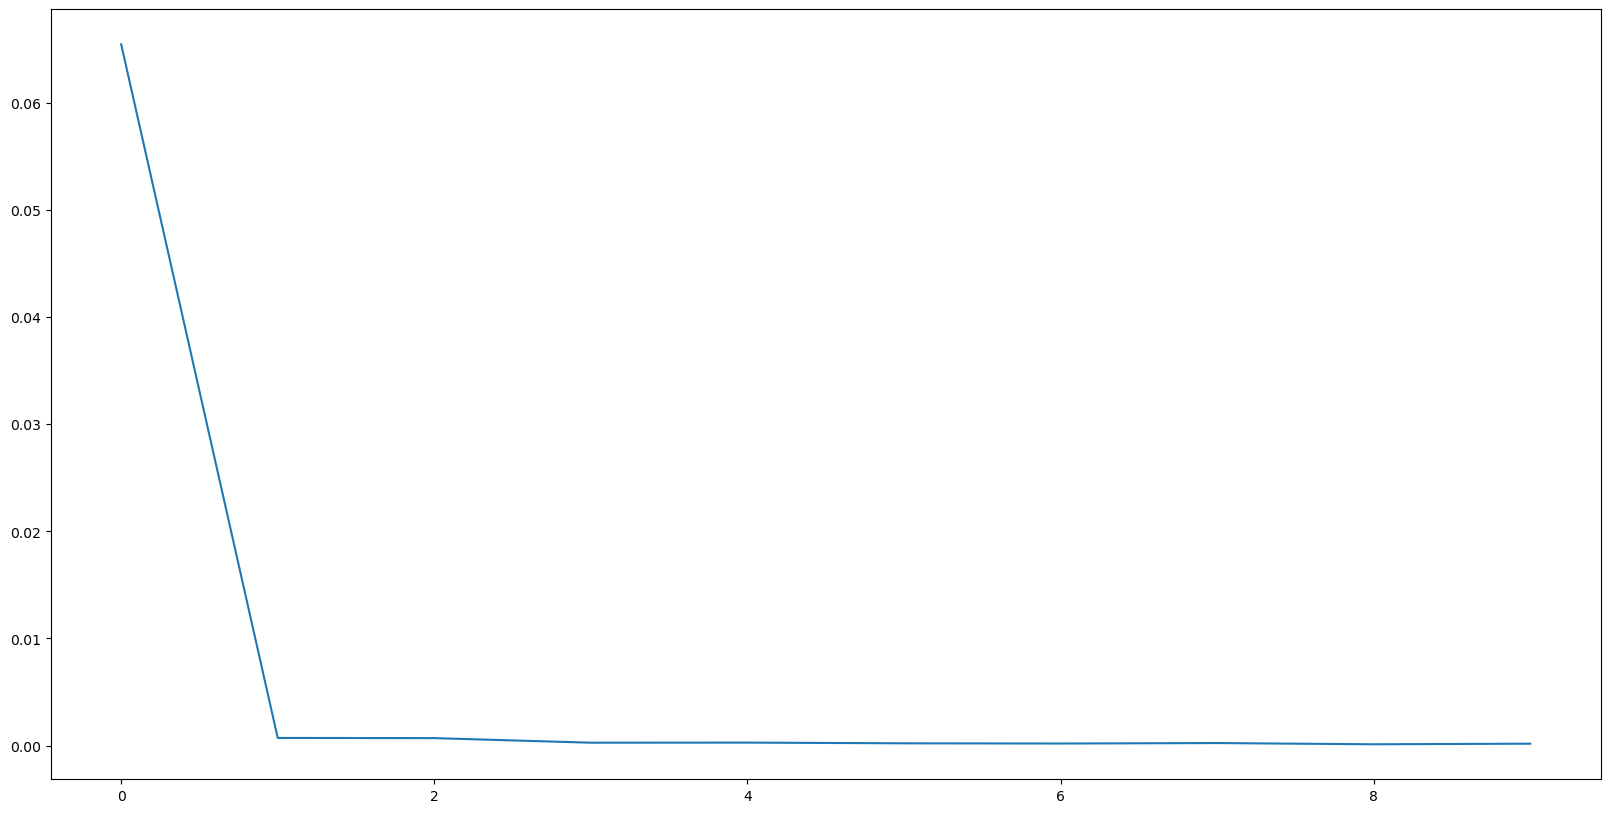

In [278]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()